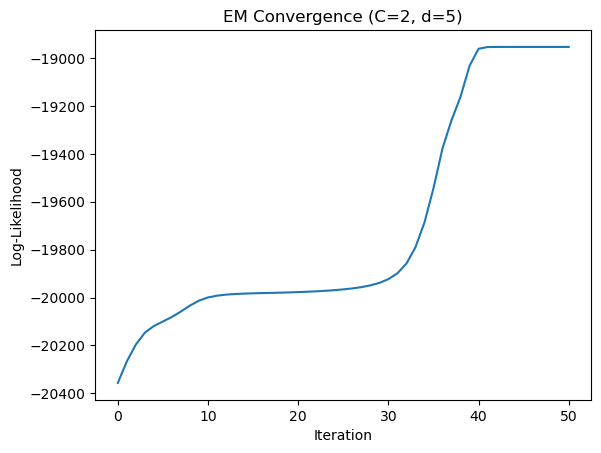

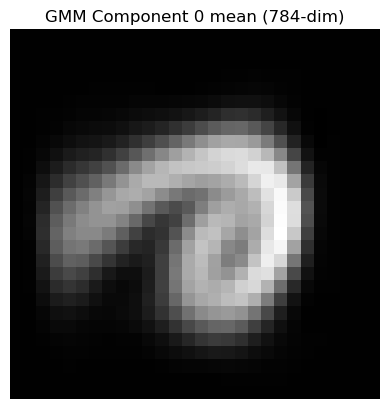

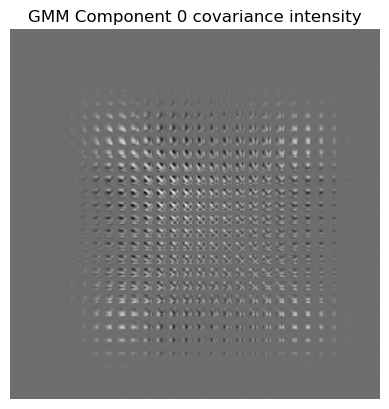

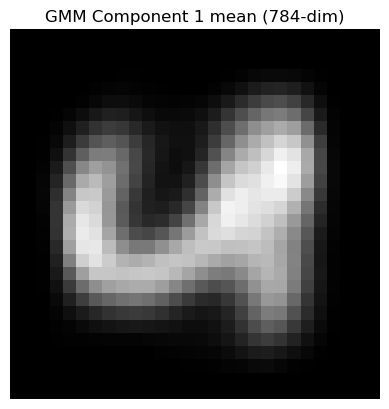

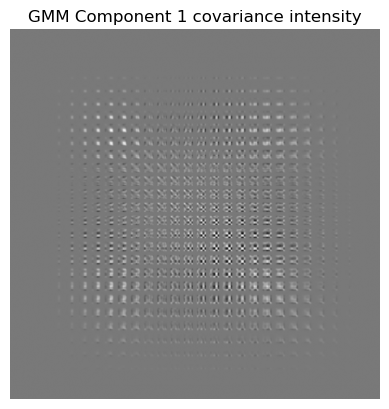

Mixture weights (pi): [0.50686455 0.49313545]
GMM per-class misclassification rates: {2: np.float64(0.05813953488372092), 6: np.float64(0.007306889352818424)}
KMeans per-class misclassification rates: {2: np.float64(0.0736434108527132), 6: np.float64(0.04697286012526092)}


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load data (expects data.dat, label.dat)
# ----------------------------
X = np.loadtxt('data.dat')          # images
y = np.loadtxt('label.dat')         # labels (2 or 6)
y = y.reshape(-1).astype(int)

# ----------------------------
# PCA to d=5 (same style as yours)
# ----------------------------
def pca_transform(X, n_components=5):
    X_mean = np.mean(X, axis=1, keepdims=True)
    Xc = X - X_mean
    cov = (Xc @ Xc.T) / X.shape[1]
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    U = eigvecs[:, idx[:n_components]]      # (784 x 5)
    X_reduced = U.T @ Xc                    # (5 x n)
    return X_reduced, U, X_mean

# ----------------------------
# Gaussian pdf (simple)
# ----------------------------
def gaussian_pdf(x, mu, Sigma):
    d = len(x)
    diff = x - mu
    invS = np.linalg.inv(Sigma)
    detS = np.linalg.det(Sigma)
    expo = -0.5 * diff.T @ invS @ diff
    norm = np.sqrt((2*np.pi)**d * detS)
    return np.exp(expo) / (norm + 1e-300)

# ----------------------------
# EM for GMM (C=2) -- FIXED covariance update
# ----------------------------
def em_gmm(X, C=2, max_iter=200, tol=1e-6, reg=1e-6, seed=0):
    d, n = X.shape
    rng = np.random.default_rng(seed)

    # init
    mu = [rng.standard_normal(d) for _ in range(C)]
    Sigma = []
    for _ in range(C):
        S = rng.standard_normal((d, d))
        Sigma.append(S @ S.T + np.eye(d))
    pi = np.ones(C) / C

    log_liks = []

    for it in range(max_iter):
        # E-step
        R = np.zeros((n, C))
        for i in range(n):
            for c in range(C):
                R[i, c] = pi[c] * gaussian_pdf(X[:, i], mu[c], Sigma[c])
            s = R[i].sum()
            if s > 0:
                R[i] /= s
            else:
                R[i] = 1.0 / C  # underflow guard

        # M-step
        N = R.sum(axis=0)  # (C,)
        for c in range(C):
            pi[c] = N[c] / n
            mu[c] = (X @ R[:, c]) / N[c]                  # (d,)

            diff = X - mu[c].reshape(-1, 1)               # (d x n)
            # *** FIX: weight columns with R[:, c] using reshape(1,-1) ***
            Sigma[c] = (diff * R[:, c].reshape(1, -1)) @ diff.T / N[c]
            Sigma[c] += reg * np.eye(d)                   # stability

        # Log-likelihood
        ll = 0.0
        for i in range(n):
            s = 0.0
            for c in range(C):
                s += pi[c] * gaussian_pdf(X[:, i], mu[c], Sigma[c])
            ll += np.log(s + 1e-300)
        log_liks.append(ll)

        if it > 0 and abs(log_liks[-1] - log_liks[-2]) < tol:
            break

    return np.array(pi), mu, Sigma, R, log_liks

# ----------------------------
# Back-project to 784-dim
# ----------------------------
def backproject_mean(mu_low, U, X_mean):
    return (X_mean + U @ mu_low.reshape(-1, 1)).reshape(-1)

def backproject_cov(Sigma_low, U):
    return U @ Sigma_low @ U.T

# ----------------------------
# Simple KMeans (K=2)
# ----------------------------
def kmeans2(Z, max_iter=50, seed=0):
    rng = np.random.default_rng(seed)
    n = Z.shape[0]
    centers = Z[rng.choice(n, 2, replace=False)]
    for _ in range(max_iter):
        d2 = ((Z[:, None, :] - centers[None, :, :])**2).sum(axis=2)
        a = np.argmin(d2, axis=1)
        new_centers = np.array([
            Z[a == j].mean(axis=0) if np.any(a == j) else centers[j]
            for j in range(2)
        ])
        if np.allclose(new_centers, centers):
            break
        centers = new_centers
    d2 = ((Z[:, None, :] - centers[None, :, :])**2).sum(axis=2)
    return np.argmin(d2, axis=1)

# ----------------------------
# Mapping & per-class error
# ----------------------------
def best_mapping(pred_clusters, true_labels):
    digits = sorted(np.unique(true_labels))  # [2,6]
    m1 = {0: digits[0], 1: digits[1]}
    m2 = {0: digits[1], 1: digits[0]}
    def acc(m): return (np.vectorize(m.get)(pred_clusters) == true_labels).mean()
    return m1 if acc(m1) >= acc(m2) else m2

def per_class_error(pred, true):
    rates = {}
    for cls in np.unique(true):
        idx = (true == cls)
        rates[int(cls)] = 1.0 - (pred[idx] == true[idx]).mean()
    return rates

# ============================
# Run pipeline
# ============================
# PCA -> 5D
X_reduced, U, X_mean = pca_transform(X, n_components=5)   # (5 x n)

# EM-GMM on reduced data
pi, mu, Sigma, R, log_liks = em_gmm(X_reduced, C=2, max_iter=200, tol=1e-6, reg=1e-6, seed=0)

# Plot EM convergence
plt.plot(log_liks)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('EM Convergence (C=2, d=5)')
plt.show()

# Map means/covs back to 784-dim and visualize
for c in range(2):
    mean_full = backproject_mean(mu[c], U, X_mean)     # (784,)
    plt.imshow(mean_full.reshape(28, 28), cmap='gray')
    plt.title(f'GMM Component {c} mean (784-dim)')
    plt.axis('off')
    plt.show()

    cov_full = backproject_cov(Sigma[c], U)            # (784 x 784)
    plt.imshow(cov_full, cmap='gray')
    plt.title(f'GMM Component {c} covariance intensity')
    plt.axis('off')
    plt.show()

# Classification with GMM
clusters_gmm = np.argmax(R, axis=1)         # (n,)
map_gmm = best_mapping(clusters_gmm, y)
pred_gmm = np.vectorize(map_gmm.get)(clusters_gmm)
err_gmm = per_class_error(pred_gmm, y)

# Baseline KMeans on reduced 5D data
Z = X_reduced.T                              # (n x 5)
km = KMeans(n_clusters=2, n_init=20, random_state=0).fit(Z)
clusters_km = km.labels_
map_km = best_mapping(clusters_km, y)
pred_km = np.vectorize(map_km.get)(clusters_km)
err_km = per_class_error(pred_km, y)

print("Mixture weights (pi):", pi)
print("GMM per-class misclassification rates:", err_gmm)
print("KMeans per-class misclassification rates:", err_km)


In [23]:
import numpy as np

# HMM parameters
pi = np.array([0.5, 0.5])  # [F, L]
A = np.array([[0.95, 0.05],
              [0.10, 0.90]])  # rows: from-state F/L, cols: to-state F/L

def emit_prob(state, face):
    # state: 0=F, 1=L; face in {1,...,6}
    if state == 0:  # Fair
        return 1/6
    else:  # Loaded
        return 0.5 if face == 6 else 0.1

# ---------- Q4(a): Posterior P(S3=L | "26663") via forward-backward ----------
obs = [2, 6, 6, 6, 3]
T, N = len(obs), 2

# Forward (alpha)
alpha = np.zeros((T, N))
for i in range(N):
    alpha[0, i] = pi[i] * emit_prob(i, obs[0])
for t in range(1, T):
    for j in range(N):
        alpha[t, j] = emit_prob(j, obs[t]) * np.sum(alpha[t-1, :] * A[:, j])

# Backward (beta)
beta = np.zeros((T, N))
beta[-1, :] = 1.0
for t in range(T-2, -1, -1):
    for i in range(N):
        beta[t, i] = np.sum(A[i, :] * np.array([emit_prob(j, obs[t+1]) for j in range(N)]) * beta[t+1, :])

t = 2  # S3
num = alpha[t, 1] * beta[t, 1]
den = (alpha[t, 0] * beta[t, 0] + alpha[t, 1] * beta[t, 1])
posterior_S3_L = num / den
print("P(S3=L | 26663) = ", posterior_S3_L)  # ~0.8852356403

# ---------- Q4(b): Viterbi path for "43666" ----------
obs2 = [4, 3, 6, 6, 6]
T2 = len(obs2)
delta = np.zeros((T2, N))
psi = np.zeros((T2, N), dtype=int)

# init
for i in range(N):
    delta[0, i] = np.log(pi[i]) + np.log(emit_prob(i, obs2[0]))
    
# recurse
for t in range(1, T2):
    for j in range(N):
        trans = delta[t-1, :] + np.log(A[:, j])
        psi[t, j] = np.argmax(trans)
        delta[t, j] = np.max(trans) + np.log(emit_prob(j, obs2[t]))
# backtrack
states = np.zeros(T2, dtype=int)
states[-1] = np.argmax(delta[-1, :])
for t in range(T2-2, -1, -1):
    states[t] = psi[t+1, states[t+1]]

path = ["F" if s == 0 else "L" for s in states]
print("Viterbi path for 43666: ", path)

P(S3=L | 26663) =  0.8852356403022789
Viterbi path for 43666:  ['L', 'L', 'L', 'L', 'L']
